# DEVELOPING A DEEP LEARNING MODEL FOR NER USING LSTM

***Name :** CHANDRAPRIYADHARSHINI C

**Reg.No: ** 212223240019

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.nn.utils.rnn import pad_sequence
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Load and prepare data
data = pd.read_csv("ner_dataset.csv", encoding="latin1").ffill()
words = list(data["Word"].unique())
tags = list(data["Tag"].unique())

if "ENDPAD" not in words:
    words.append("ENDPAD")

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: t for t, i in tag2idx.items()}

In [5]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())
print("Unique tags are:", tags)

Unique words in corpus: 35177
Unique tags in corpus: 17
Unique tags are: ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


In [11]:
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [15]:
class SentenceGetter:
    def __init__(self, data):
        self.grouped = data.groupby("Sentence #", group_keys=False)[["Word", "Tag"]].apply(
            lambda s: [(w, t) for w, t in zip(s["Word"], s["Tag"])]
        )
        self.sentences = list(self.grouped)

getter = SentenceGetter(data)
sentences = getter.sentences

In [16]:
# Encode sentences
X = [[word2idx[w] for w, t in s] for s in sentences]
y = [[tag2idx[t] for w, t in s] for s in sentences]

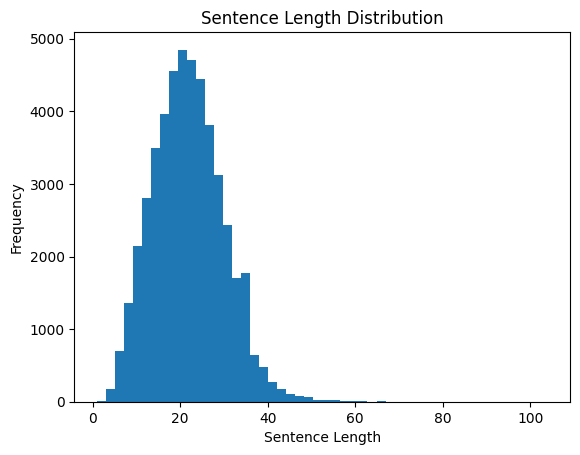

In [17]:
# Visualize sentence length distribution
plt.hist([len(s) for s in sentences], bins=50)
plt.title("Sentence Length Distribution")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.show()

In [18]:
# Pad sequences
max_len = 50
X_pad = pad_sequence([torch.tensor(seq) for seq in X], batch_first=True, padding_value=word2idx["ENDPAD"])
y_pad = pad_sequence([torch.tensor(seq) for seq in y], batch_first=True, padding_value=tag2idx["O"])
X_pad = X_pad[:, :max_len]
y_pad = y_pad[:, :max_len]

In [19]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_pad, test_size=0.2, random_state=1)

In [20]:
# Dataset class
class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {
            "input_ids": self.X[idx],
            "labels": self.y[idx]
        }

train_loader = DataLoader(NERDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(NERDataset(X_test, y_test), batch_size=32)

In [21]:
# Model Definition
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128, hidden_dim=256):
        super(BiLSTMTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word2idx["ENDPAD"])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, input_ids):
        embeds = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embeds)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        return out

# Initialize model
model = BiLSTMTagger(len(word2idx) + 1, len(tag2idx)).to(device)

In [22]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss(ignore_index=tag2idx["O"])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Training and Evaluation Functions
def train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs=3):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = loss_fn(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch["input_ids"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids)
                loss = loss_fn(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
                val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

In [24]:
def evaluate_model(model, test_loader, X_test, y_test):
    model.eval()
    true_tags, pred_tags = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=-1)
            for i in range(len(labels)):
                for j in range(len(labels[i])):
                    if labels[i][j] != tag2idx["O"]:
                        true_tags.append(idx2tag[labels[i][j].item()])
                        pred_tags.append(idx2tag[preds[i][j].item()])
    print("\nClassification Report:")
    print(classification_report(true_tags, pred_tags, zero_division=0))

In [25]:
# Run Training and Evaluation
train_losses, val_losses = train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs=3)
evaluate_model(model, test_loader, X_test, y_test)

Epoch [1/3] - Train Loss: 0.8465, Val Loss: 0.5583
Epoch [2/3] - Train Loss: 0.4619, Val Loss: 0.4736
Epoch [3/3] - Train Loss: 0.3477, Val Loss: 0.4533

Classification Report:
              precision    recall  f1-score   support

       B-art       1.00      0.01      0.02        96
       B-eve       0.78      0.32      0.45        78
       B-geo       0.86      0.91      0.88      7377
       B-gpe       0.94      0.93      0.94      3176
       B-nat       0.66      0.62      0.64        40
       B-org       0.78      0.75      0.76      3907
       B-per       0.81      0.84      0.83      3362
       B-tim       0.95      0.93      0.94      4104
       I-art       0.00      0.00      0.00        86
       I-eve       0.62      0.14      0.23        70
       I-geo       0.80      0.79      0.79      1448
       I-gpe       0.80      0.48      0.60        33
       I-nat       0.67      0.14      0.24        14
       I-org       0.83      0.81      0.82      3252
       I-per

Name: CHANDRAPRIYADHARSHINI C
Register Number: 212223240019


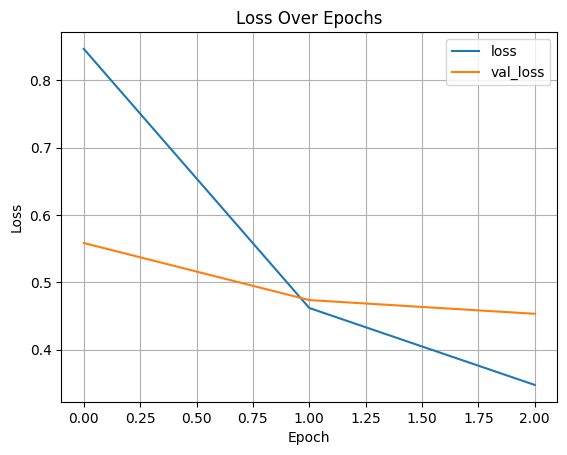

In [26]:
# Plot Loss
print('Name: CHANDRAPRIYADHARSHINI C')
print('Register Number: 212223240019')
history_df = pd.DataFrame({"loss": train_losses, "val_loss": val_losses})
history_df.plot(title="Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [27]:
# Inference and Prediction
i = 125
model.eval()
sample = X_test[i].unsqueeze(0).to(device)
output = model(sample)
preds = torch.argmax(output, dim=-1).squeeze().cpu().numpy()
true = y_test[i].numpy()

print('Name: CHANDRAPRIYADHARSHINI C')
print('Register Number: 212223240019')
print("{:<15} {:<10} {}\n{}".format("Word", "True", "Pred", "-" * 40))
for w_id, true_tag, pred_tag in zip(X_test[i], y_test[i], preds):
    if w_id.item() != word2idx["ENDPAD"]:
        word = words[w_id.item() - 1]
        true_label = tags[true_tag.item()]
        pred_label = tags[pred_tag]
        print(f"{word:<15} {true_label:<10} {pred_label}")

Name: CHANDRAPRIYADHARSHINI C
Register Number: 212223240019
Word            True       Pred
----------------------------------------
Palestinian     B-gpe      B-gpe
officials       O          B-gpe
say             O          B-geo
two             O          B-tim
Palestinians    B-gpe      B-gpe
have            O          B-gpe
been            O          B-per
killed          O          B-geo
in              O          B-tim
an              O          B-geo
accidental      O          B-geo
explosion       O          B-tim
in              O          B-tim
a               O          B-geo
West            B-org      B-org
Bank            I-org      I-org
refugee         O          I-org
camp            O          I-org
.               O          B-tim
